# Train Classifier For News Classification
> ## * Word2Vec

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os
from glob import glob

from numba import jit

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,  accuracy_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot

import xgboost as xgb

import matplotlib.pyplot as plt


import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17621844402533053948
]


In [3]:
import Basic_Module as bm

In [4]:
cores = multiprocessing.cpu_count()
print (cores)

4


## Document Labeling

In [5]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags category')

> * words : 기사에서 나온 단어들 or keywords
> * tags : 문서 tag
> * classes : category
>> 기사분류가 daum보다 naver에서 더 세분화되어 있기 때문에 네이버의 category 분류를 이용하기로 함

## Category

In [6]:
if os.path.isfile('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_word2vec_news_classification.pickled'):
    le = pickle.load(open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_word2vec_news_classification.pickled','rb'))
else:
    le = LabelEncoder()
    le.fit(naverData['category'])
    pickle.dump(le, open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_word2vec_news_classification.pickled','wb'))
print (le.classes_)

['IT/과학' '경제' '사회' '생활/문화' '세계' '스포츠' '연예' '정치']


In [7]:
if sys.platform =='darwin':
    loadModelPath = './news_model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/news_model/'
saveTrainPath = './data/pre_data/news_train_test_Data2/'
saveClassifierPath = './data/pre_data/news_classifier/'

## Tagging Twitter

> 전 단계에서 필요한 사전 데이터는 만들어 둠

### Train Data Set & Test Data Set

In [8]:
trainName = './data/pre_data/news_train_test_Data/pre_data_word2vec_train_for_news_classification_by_ct.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_word2vec_test_for_news_classification_by_ct.pickled'

In [9]:
if os.path.isfile(trainName) & os.path.isfile(testName):
    train = pickle.load(open(trainName, 'rb'))
    test = pickle.load(open(testName, 'rb'))
else:
    train, test = train_test_split(w2v_docs, test_size = 0.15)
    pickle.dump(train,open(trainName,'wb'))
    pickle.dump(test,open(testName,'wb'))

### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [10]:
tfidf = bm.Build_tfidf(train)

100%|██████████| 12852/12852 [00:00<00:00, 769491.60it/s]


(12852, 73763)
vocab size : 73763


In [11]:
x_train = [ x.words for x in tqdm(train)] 
y_train = np.array([ x.category for x in tqdm(train)])
x_test = [ x.words for x in tqdm(test)] 
y_test = np.array([ x.category for x in tqdm(test)])

100%|██████████| 2268/2268 [00:00<00:00, 851018.20it/s]


In [12]:
train_y2, test_y2 = bm.ReMake_Outcome(y_train, y_test)

100%|██████████| 2268/2268 [00:00<00:00, 723452.85it/s]


### Load Model

In [13]:
model1 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-ct.model')
model2 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-ct.model')
model3 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-ct.model')

### model 1

In [14]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model1, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model1,'ct')

 28%|██▊       | 22317/80534 [00:00<00:00, 111564.89it/s]

Word2Vec(vocab=80534, size=500, alpha=0.025)


100%|██████████| 80534/80534 [00:00<00:00, 99925.65it/s] 
7it [00:00, 62.31it/s]

running time : 0:00:00.811046
Vectorizing Train Data


12852it [04:30, 47.53it/s]


scaling Train Data


4it [00:00, 35.02it/s]

running time : 0:04:31.239537
Vectorizing Test Data


2268it [00:52, 43.04it/s]


scaling Test Data
running time : 0:00:52.782001
total running time : 0:05:24.832584


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [15]:
%%time
bm.Make_TSNE2(2, model1, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 48603.13it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.875s...
[t-SNE] Computed neighbors for 10000 samples in 221.331s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.136822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 152.429779
[t-SNE] Error after 1000 iterations: 4.408333


CPU times: user 12min 52s, sys: 43.1 s, total: 13min 35s
Wall time: 18min 16s


#### 분류모델 :  Logistic Regression

In [16]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8871252204585538
classification report
             precision    recall  f1-score   support

          0       0.86      0.89      0.87       281
          1       0.89      0.81      0.85       291
          2       0.79      0.82      0.80       248
          3       0.84      0.85      0.84       299
          4       0.86      0.85      0.85       282
          5       0.99      0.98      0.99       296
          6       0.98      0.97      0.98       284
          7       0.88      0.91      0.90       287

avg / total       0.89      0.89      0.89      2268

CPU times: user 56.2 s, sys: 834 ms, total: 57 s
Wall time: 1min 4s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

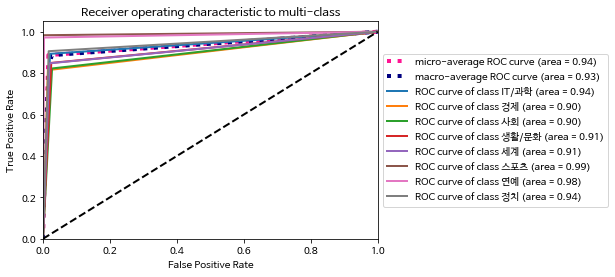

In [17]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

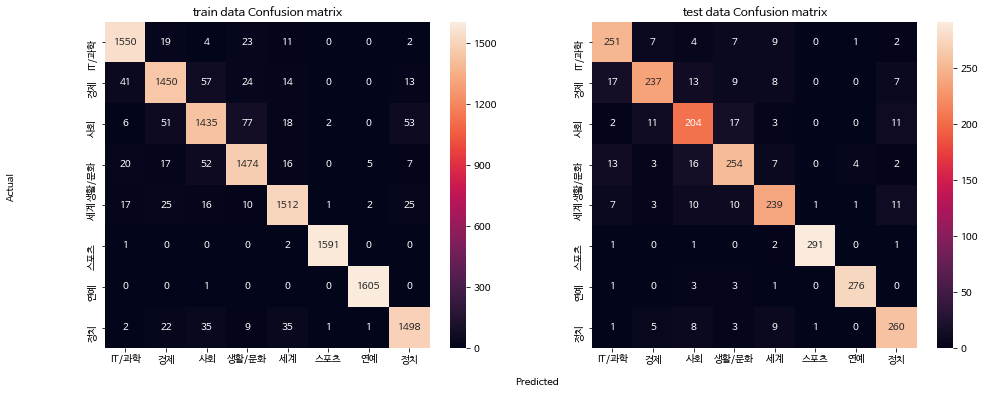

In [18]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [19]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8910934744268078
classification report
             precision    recall  f1-score   support

          0       0.87      0.92      0.90       281
          1       0.86      0.85      0.86       291
          2       0.78      0.82      0.80       248
          3       0.88      0.84      0.86       299
          4       0.87      0.86      0.86       282
          5       1.00      0.97      0.98       296
          6       0.95      0.96      0.96       284
          7       0.90      0.90      0.90       287

avg / total       0.89      0.89      0.89      2268

CPU times: user 32.7 s, sys: 258 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

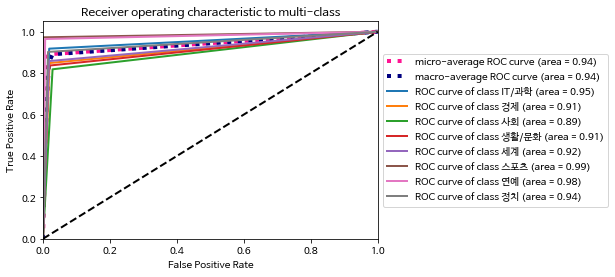

In [20]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

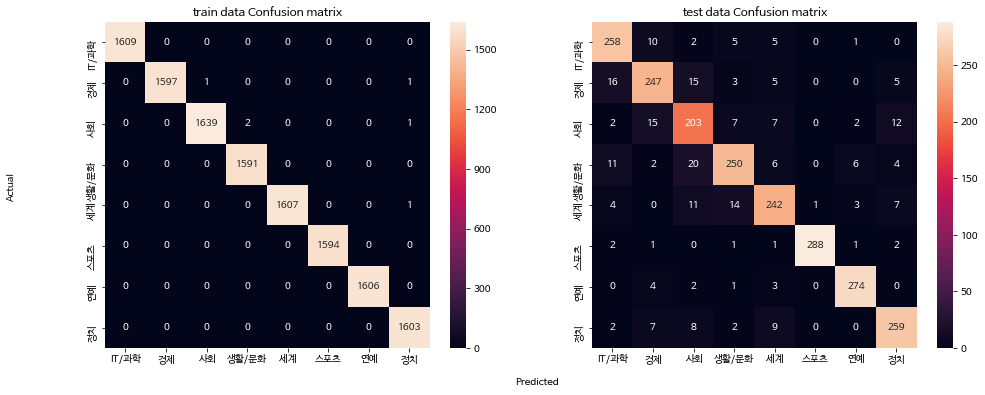

In [21]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [22]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9140211640211641
classification report
             precision    recall  f1-score   support

          0       0.90      0.95      0.92       281
          1       0.90      0.85      0.87       291
          2       0.85      0.85      0.85       248
          3       0.91      0.90      0.90       299
          4       0.88      0.89      0.88       282
          5       0.99      0.98      0.98       296
          6       0.97      0.97      0.97       284
          7       0.91      0.92      0.91       287

avg / total       0.91      0.91      0.91      2268

CPU times: user 1min 2s, sys: 737 ms, total: 1min 2s
Wall time: 1min 9s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

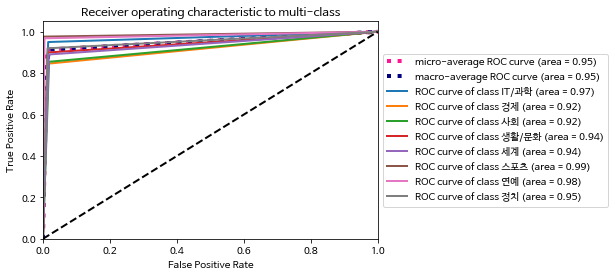

In [23]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

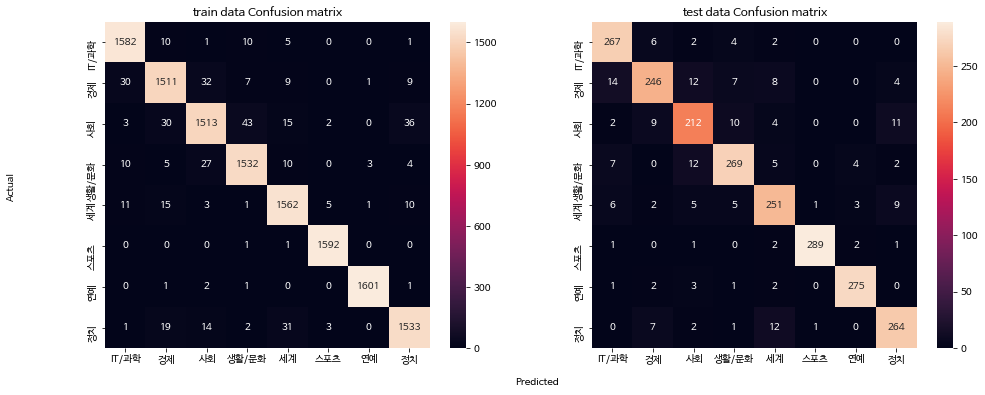

In [24]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [25]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 49.9 ms, sys: 32.2 ms, total: 82 ms
Wall time: 79 ms


In [26]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.76623	eval-mlogloss:1.7952
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.55172	eval-mlogloss:1.61153
[2]	train-mlogloss:1.37936	eval-mlogloss:1.46122
[3]	train-mlogloss:1.24465	eval-mlogloss:1.33939
[4]	train-mlogloss:1.12828	eval-mlogloss:1.23358
[5]	train-mlogloss:1.02974	eval-mlogloss:1.14621
[6]	train-mlogloss:0.944139	eval-mlogloss:1.06909
[7]	train-mlogloss:0.867353	eval-mlogloss:1.00118
[8]	train-mlogloss:0.800468	eval-mlogloss:0.94256
[9]	train-mlogloss:0.742139	eval-mlogloss:0.890882
[10]	train-mlogloss:0.689143	eval-mlogloss:0.84552
[11]	train-mlogloss:0.641963	eval-mlogloss:0.803427
[12]	train-mlogloss:0.599938	eval-mlogloss:0.76579
[13]	train-mlogloss:0.560574	eval-mlogloss:0.732191
[14]	train-mlogloss:0.525009	eval-mlogloss:0.70131
[15]	train-mlogloss:0.494286	eval-mlogloss:0.673907
[16]	train-mlogloss:0.465705	eval-mlogloss:0.6

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

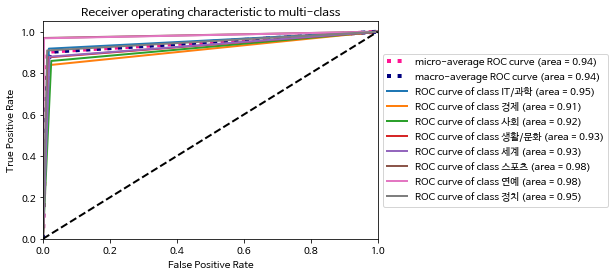

In [27]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

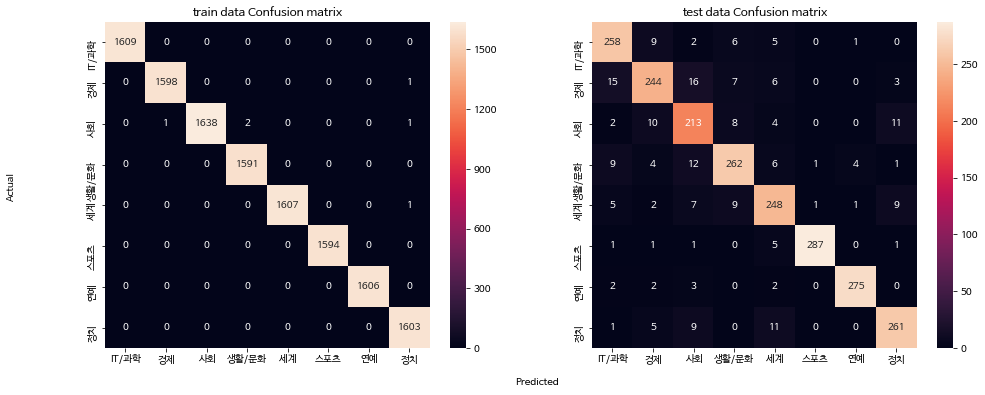

In [28]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [29]:
del classifier
del classifier2
del classifier3
del gbm

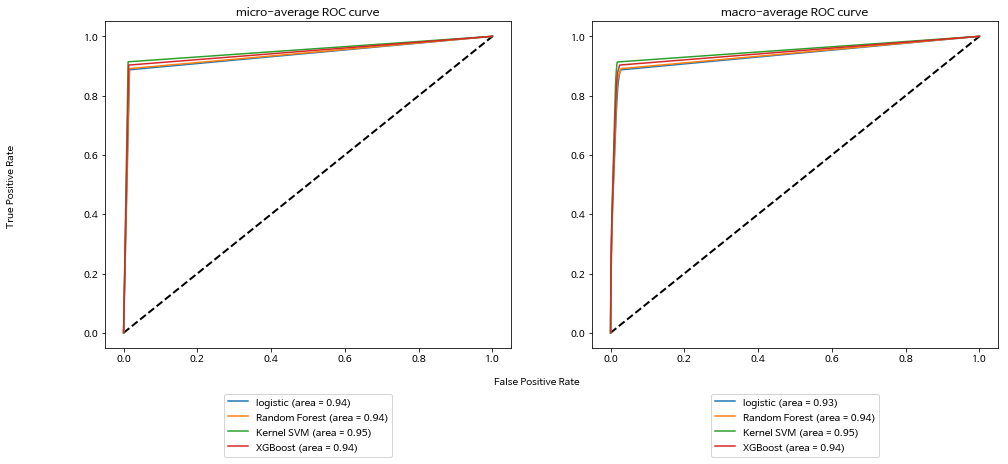

In [30]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [31]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5225
Accuracy: 0.8907


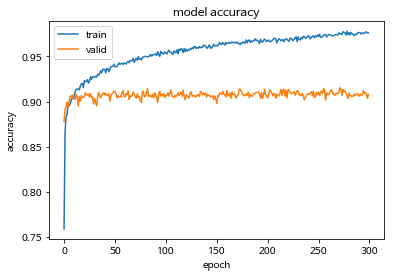

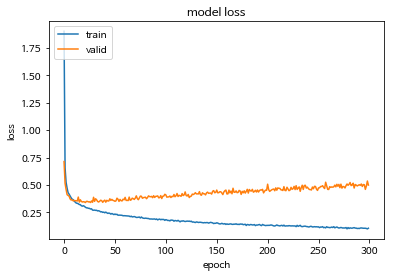

In [33]:
bm.plot_history(history)

In [34]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.8517
Accuracy: 0.8854


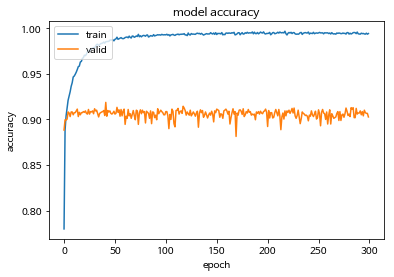

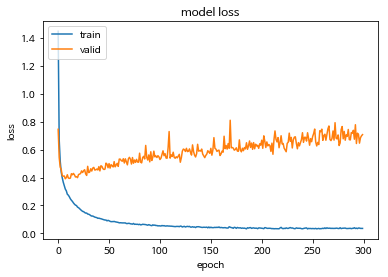

In [35]:
bm.plot_history(history)

### model 2

In [36]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model2, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model2,'ct')

 10%|▉         | 7831/80534 [00:00<00:00, 78289.54it/s]

Word2Vec(vocab=80534, size=500, alpha=0.025)


100%|██████████| 80534/80534 [00:01<00:00, 77366.61it/s]
1it [00:00,  7.34it/s]

running time : 0:00:01.047385
Vectorizing Train Data


12852it [03:20, 64.05it/s]


scaling Train Data


6it [00:00, 44.77it/s]

running time : 0:03:21.008268
Vectorizing Test Data


2268it [00:34, 66.26it/s]


scaling Test Data
running time : 0:00:34.283944
total running time : 0:03:56.339597


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [37]:
%%time
bm.Make_TSNE2(2, model2, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 107956.49it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.641s...
[t-SNE] Computed neighbors for 10000 samples in 115.591s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.293128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.645073
[t-SNE] Error after 1000 iterations: 2.821577


CPU times: user 9min 28s, sys: 52.1 s, total: 10min 20s
Wall time: 10min 9s


#### 분류모델 :  Logistic Regression

In [38]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.9034391534391535
classification report
             precision    recall  f1-score   support

          0       0.91      0.92      0.92       281
          1       0.88      0.83      0.86       291
          2       0.83      0.84      0.83       248
          3       0.89      0.87      0.88       299
          4       0.86      0.87      0.87       282
          5       0.99      0.98      0.98       296
          6       0.97      0.98      0.97       284
          7       0.89      0.92      0.91       287

avg / total       0.90      0.90      0.90      2268

CPU times: user 1min 5s, sys: 249 ms, total: 1min 5s
Wall time: 1min 40s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

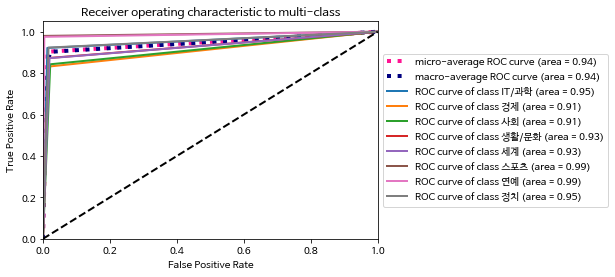

In [39]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

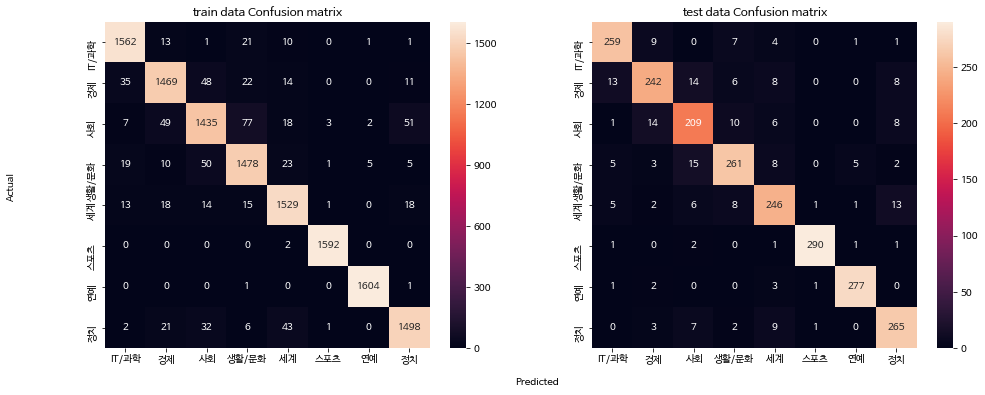

In [40]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [41]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.9091710758377425
classification report
             precision    recall  f1-score   support

          0       0.89      0.94      0.92       281
          1       0.88      0.87      0.88       291
          2       0.84      0.83      0.84       248
          3       0.91      0.85      0.88       299
          4       0.88      0.89      0.89       282
          5       1.00      0.98      0.99       296
          6       0.96      0.98      0.97       284
          7       0.91      0.92      0.91       287

avg / total       0.91      0.91      0.91      2268

CPU times: user 35.5 s, sys: 232 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

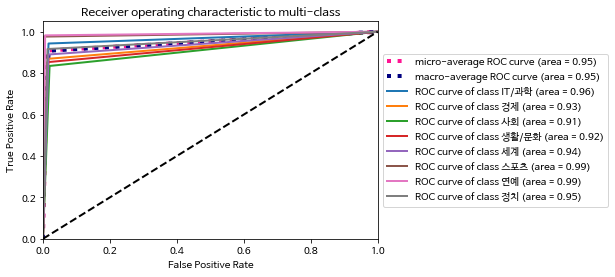

In [42]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

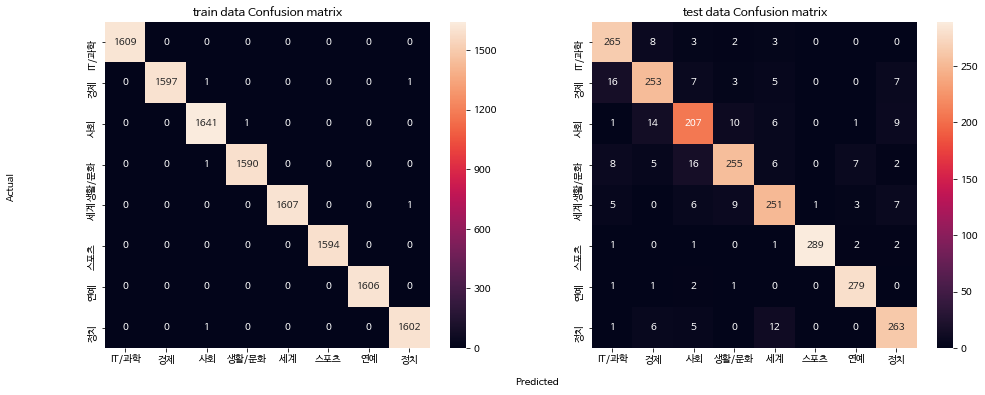

In [43]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [44]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9184303350970018
classification report
             precision    recall  f1-score   support

          0       0.90      0.94      0.92       281
          1       0.91      0.87      0.89       291
          2       0.86      0.84      0.85       248
          3       0.89      0.91      0.90       299
          4       0.90      0.89      0.89       282
          5       0.99      0.99      0.99       296
          6       0.98      0.97      0.97       284
          7       0.90      0.93      0.91       287

avg / total       0.92      0.92      0.92      2268

CPU times: user 42.9 s, sys: 217 ms, total: 43.2 s
Wall time: 58.2 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

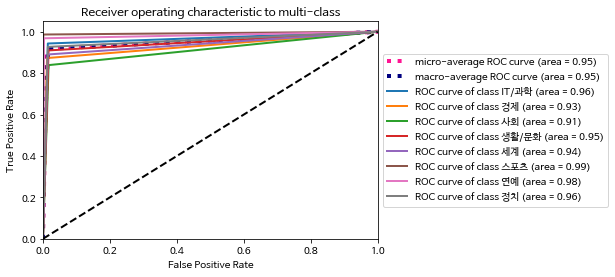

In [45]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

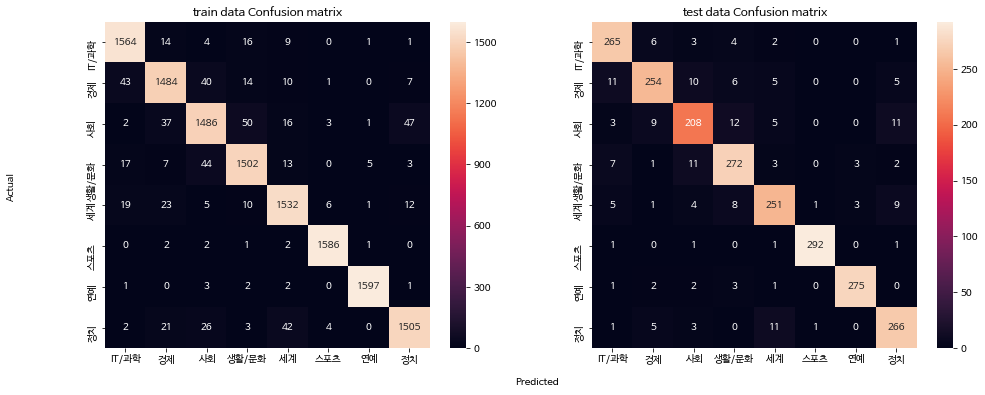

In [46]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [47]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 64.4 ms, sys: 37.7 ms, total: 102 ms
Wall time: 124 ms


In [48]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.65216	eval-mlogloss:1.67348
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.38771	eval-mlogloss:1.42555
[2]	train-mlogloss:1.19739	eval-mlogloss:1.24737
[3]	train-mlogloss:1.04726	eval-mlogloss:1.10646
[4]	train-mlogloss:0.925271	eval-mlogloss:0.993705
[5]	train-mlogloss:0.824792	eval-mlogloss:0.90151
[6]	train-mlogloss:0.741403	eval-mlogloss:0.825664
[7]	train-mlogloss:0.669745	eval-mlogloss:0.757626
[8]	train-mlogloss:0.608167	eval-mlogloss:0.702533
[9]	train-mlogloss:0.555525	eval-mlogloss:0.656259
[10]	train-mlogloss:0.509287	eval-mlogloss:0.613658
[11]	train-mlogloss:0.469597	eval-mlogloss:0.577184
[12]	train-mlogloss:0.434264	eval-mlogloss:0.546022
[13]	train-mlogloss:0.403459	eval-mlogloss:0.517879
[14]	train-mlogloss:0.376232	eval-mlogloss:0.493257
[15]	train-mlogloss:0.351382	eval-mlogloss:0.47197
[16]	train-mlogloss:0.329394	eval-mlo

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

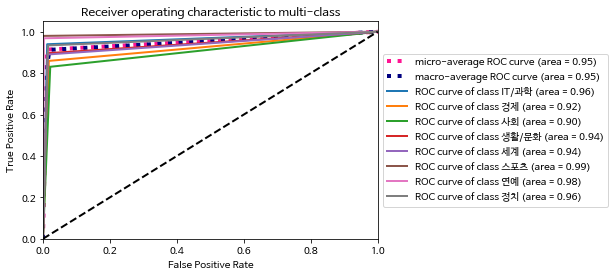

In [49]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

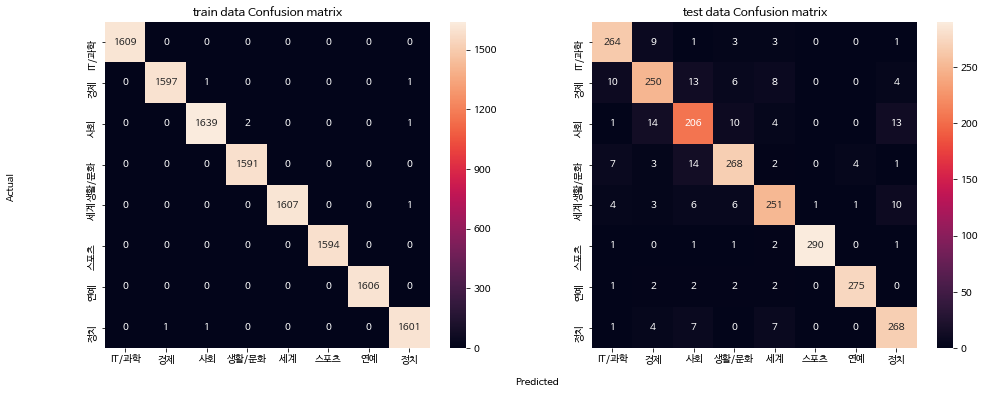

In [50]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [51]:
del classifier
del classifier2
del classifier3
del gbm

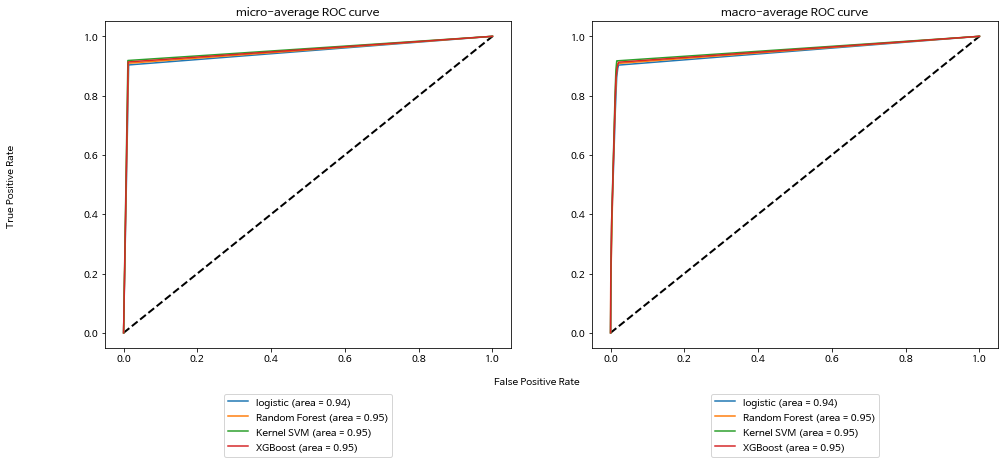

In [52]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [53]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [54]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.4189
Accuracy: 0.9105


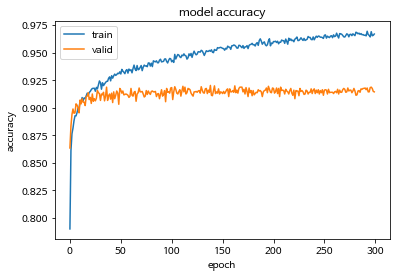

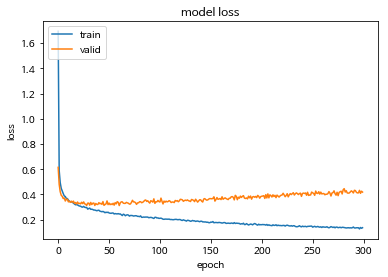

In [55]:
bm.plot_history(history)

In [56]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.7437
Accuracy: 0.9061


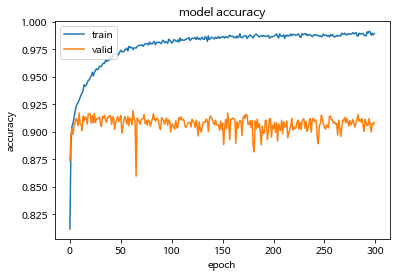

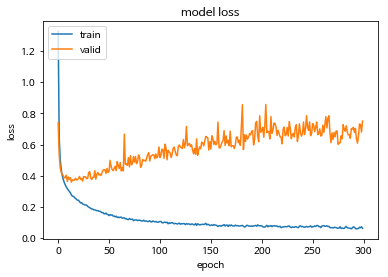

In [57]:
bm.plot_history(history)

#### model 3

In [58]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model3, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model3,'ct')

  6%|▌         | 4813/80534 [00:00<00:01, 48115.59it/s]

Word2Vec(vocab=80534, size=500, alpha=0.025)


100%|██████████| 80534/80534 [00:01<00:00, 67103.28it/s]
1it [00:00,  6.14it/s]

running time : 0:00:01.208899
Vectorizing Train Data


12852it [03:18, 64.64it/s]


scaling Train Data


4it [00:00, 33.28it/s]

running time : 0:03:19.203687
Vectorizing Test Data


2268it [00:32, 70.15it/s]


scaling Test Data
running time : 0:00:32.385000
total running time : 0:03:52.797586


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [59]:
%%time
bm.Make_TSNE2(2, model3, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 70622.95it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.665s...
[t-SNE] Computed neighbors for 10000 samples in 125.522s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.252239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.575424
[t-SNE] Error after 1000 iterations: 3.209903


CPU times: user 12min 14s, sys: 56.9 s, total: 13min 11s
Wall time: 11min 55s


#### 분류모델 :  Logistic Regression

In [60]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.9087301587301587
classification report
             precision    recall  f1-score   support

          0       0.90      0.94      0.92       281
          1       0.91      0.83      0.87       291
          2       0.80      0.84      0.82       248
          3       0.88      0.87      0.88       299
          4       0.89      0.89      0.89       282
          5       0.99      0.98      0.98       296
          6       0.97      0.98      0.97       284
          7       0.92      0.94      0.93       287

avg / total       0.91      0.91      0.91      2268

CPU times: user 41 s, sys: 193 ms, total: 41.2 s
Wall time: 42.1 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

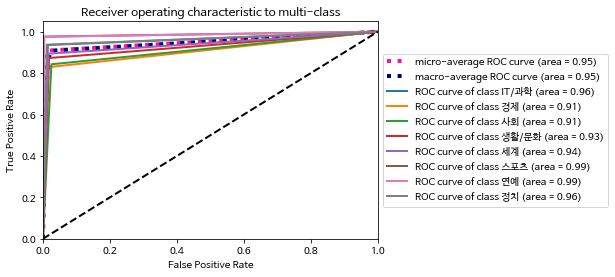

In [61]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

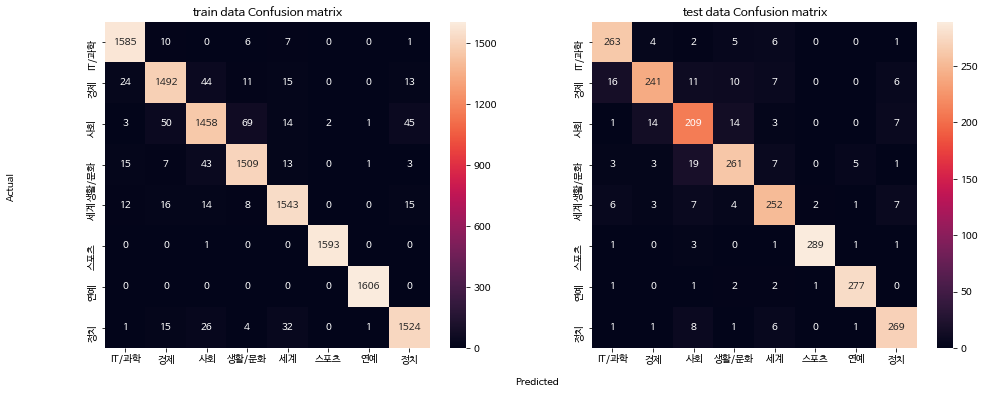

In [62]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [63]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.9007936507936508
classification report
             precision    recall  f1-score   support

          0       0.89      0.93      0.91       281
          1       0.86      0.87      0.87       291
          2       0.80      0.81      0.81       248
          3       0.90      0.85      0.87       299
          4       0.90      0.87      0.88       282
          5       0.99      0.98      0.99       296
          6       0.96      0.98      0.97       284
          7       0.88      0.91      0.90       287

avg / total       0.90      0.90      0.90      2268

CPU times: user 35.2 s, sys: 248 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

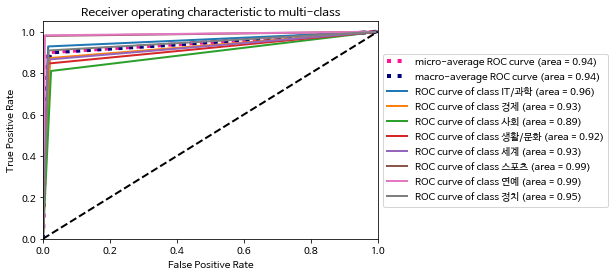

In [64]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

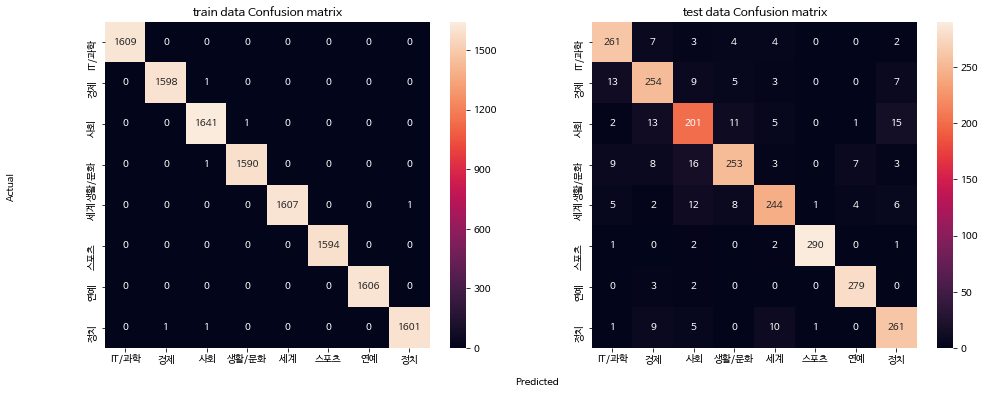

In [65]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [66]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9241622574955908
classification report
             precision    recall  f1-score   support

          0       0.89      0.94      0.92       281
          1       0.91      0.87      0.89       291
          2       0.89      0.84      0.86       248
          3       0.90      0.93      0.91       299
          4       0.91      0.91      0.91       282
          5       0.99      0.99      0.99       296
          6       0.99      0.98      0.98       284
          7       0.91      0.92      0.92       287

avg / total       0.92      0.92      0.92      2268

CPU times: user 46.5 s, sys: 129 ms, total: 46.6 s
Wall time: 46.7 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

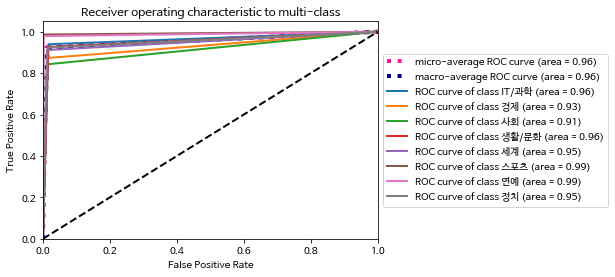

In [67]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

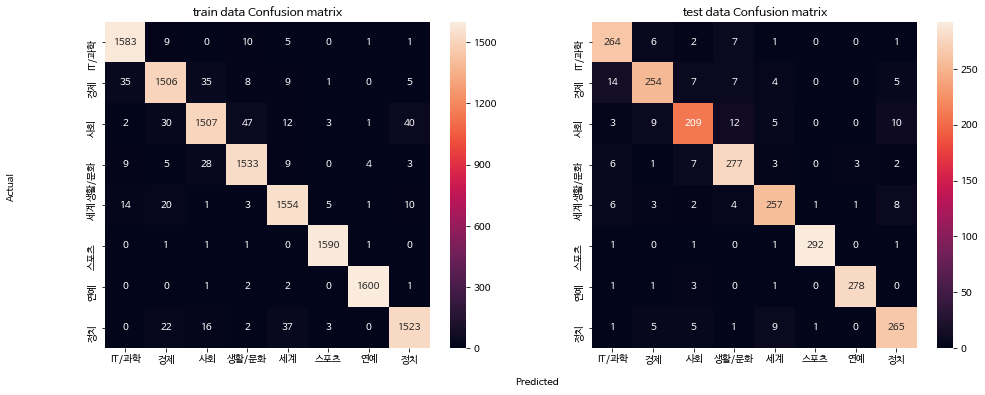

In [68]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [69]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 69.6 ms, sys: 41.9 ms, total: 112 ms
Wall time: 220 ms


In [70]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.67164	eval-mlogloss:1.69
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.4201	eval-mlogloss:1.45183
[2]	train-mlogloss:1.23328	eval-mlogloss:1.27686
[3]	train-mlogloss:1.08635	eval-mlogloss:1.1365
[4]	train-mlogloss:0.966376	eval-mlogloss:1.0272
[5]	train-mlogloss:0.86709	eval-mlogloss:0.936706
[6]	train-mlogloss:0.783761	eval-mlogloss:0.861892
[7]	train-mlogloss:0.710315	eval-mlogloss:0.794651
[8]	train-mlogloss:0.648193	eval-mlogloss:0.738107
[9]	train-mlogloss:0.593426	eval-mlogloss:0.689509
[10]	train-mlogloss:0.545649	eval-mlogloss:0.647866
[11]	train-mlogloss:0.503585	eval-mlogloss:0.610033
[12]	train-mlogloss:0.466831	eval-mlogloss:0.578564
[13]	train-mlogloss:0.433533	eval-mlogloss:0.549256
[14]	train-mlogloss:0.404561	eval-mlogloss:0.524684
[15]	train-mlogloss:0.37799	eval-mlogloss:0.501779
[16]	train-mlogloss:0.353956	eval-mlogloss:0

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

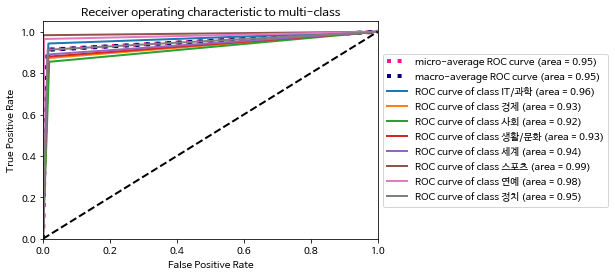

In [71]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

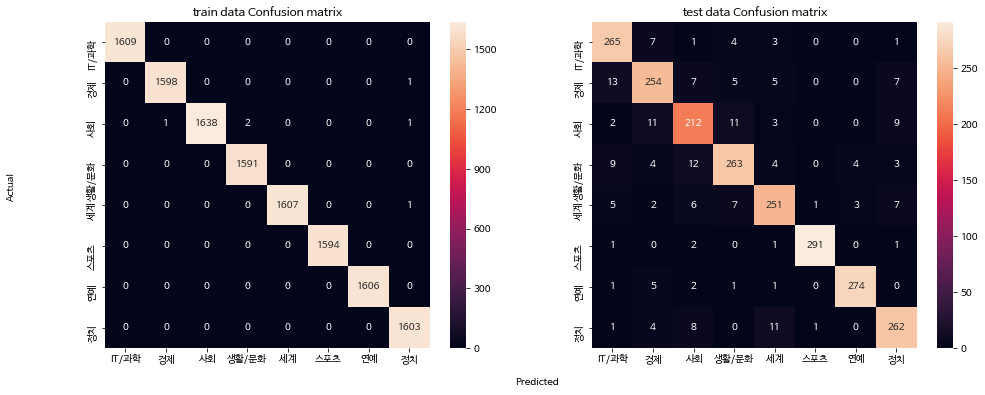

In [72]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [73]:
del classifier
del classifier2
del classifier3
del gbm

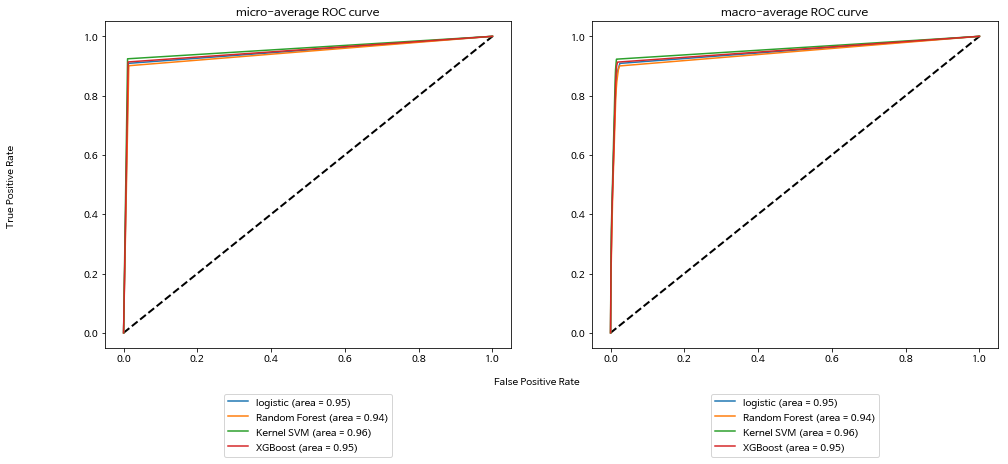

In [74]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [75]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [76]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.4494
Accuracy: 0.9189


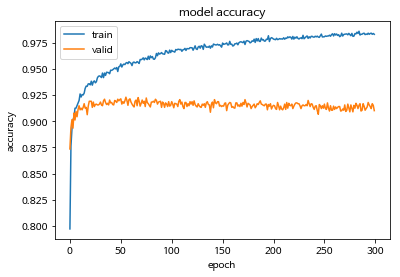

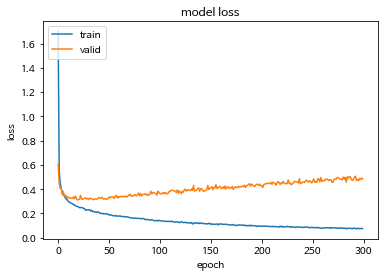

In [77]:
bm.plot_history(history)

In [78]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.6722
Accuracy: 0.9149


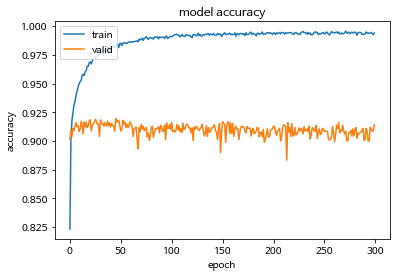

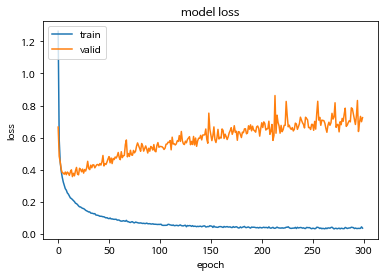

In [79]:
bm.plot_history(history)

## Tagging Mecab

> 전 단계에서 필요한 사전 데이터는 만들어 둠

### Train Data Set & Test Data Set

In [80]:
trainName = './data/pre_data/news_train_test_Data/pre_data_word2vec_train_for_news_classification_by_mecab.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_word2vec_test_for_news_classification_by_mecab.pickled'

In [81]:
if os.path.isfile(trainName) & os.path.isfile(testName):
    train = pickle.load(open(trainName, 'rb'))
    test = pickle.load(open(testName, 'rb'))
else:
    train, test = train_test_split(w2v_docs, test_size = 0.15)
    pickle.dump(train,open(trainName,'wb'))
    pickle.dump(test,open(testName,'wb'))

### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [82]:
tfidf = bm.Build_tfidf(train)

100%|██████████| 12852/12852 [00:00<00:00, 726632.00it/s]


(12852, 73416)
vocab size : 73416


In [83]:
x_train = [ x.words for x in tqdm(train)] 
y_train = np.array([ x.category for x in tqdm(train)])
x_test = [ x.words for x in tqdm(test)] 
y_test = np.array([ x.category for x in tqdm(test)])

100%|██████████| 2268/2268 [00:00<00:00, 566028.89it/s]


In [84]:
train_y2, test_y2 = bm.ReMake_Outcome(y_train, y_test)

100%|██████████| 2268/2268 [00:00<00:00, 534931.20it/s]


### Load Model

In [85]:
model1 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-mecab.model')
model2 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-mecab.model')
model3 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-mecab.model')

### model 1

In [86]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model1, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model1,'mecab')

 20%|█▉        | 15665/80260 [00:00<00:00, 78308.18it/s]

Word2Vec(vocab=80260, size=500, alpha=0.025)


100%|██████████| 80260/80260 [00:00<00:00, 84289.11it/s]
3it [00:00, 28.58it/s]

running time : 0:00:00.960090
Vectorizing Train Data


12852it [02:59, 71.45it/s]


scaling Train Data


11it [00:00, 101.36it/s]

running time : 0:03:00.262264
Vectorizing Test Data


2268it [00:28, 79.52it/s]


scaling Test Data
running time : 0:00:28.577928
total running time : 0:03:29.800282


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [87]:
%%time
bm.Make_TSNE2(2, model1, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 85495.10it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.436s...
[t-SNE] Computed neighbors for 10000 samples in 142.635s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.136317
[t-SNE] KL divergence after 250 iterations with early exaggeration: 149.571136
[t-SNE] Error after 1000 iterations: 4.399353


CPU times: user 12min 40s, sys: 59.8 s, total: 13min 40s
Wall time: 15min 40s


#### 분류모델 :  Logistic Regression

In [88]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8919753086419753
classification report
             precision    recall  f1-score   support

          0       0.91      0.92      0.91       303
          1       0.88      0.84      0.86       287
          2       0.81      0.81      0.81       271
          3       0.83      0.84      0.83       274
          4       0.86      0.84      0.85       279
          5       0.97      0.99      0.98       279
          6       0.97      0.99      0.98       296
          7       0.90      0.90      0.90       279

avg / total       0.89      0.89      0.89      2268

CPU times: user 58.2 s, sys: 611 ms, total: 58.8 s
Wall time: 1min 6s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

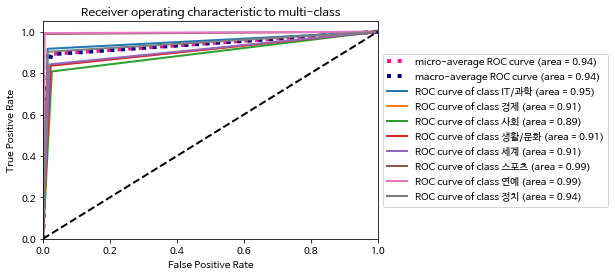

In [89]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

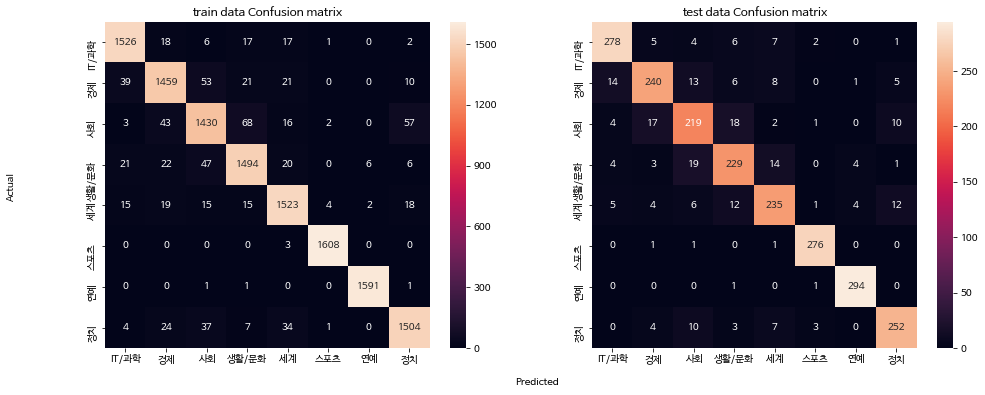

In [90]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [91]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8853615520282186
classification report
             precision    recall  f1-score   support

          0       0.91      0.90      0.91       303
          1       0.85      0.86      0.86       287
          2       0.78      0.82      0.80       271
          3       0.85      0.82      0.84       274
          4       0.85      0.85      0.85       279
          5       0.98      0.98      0.98       279
          6       0.96      0.97      0.96       296
          7       0.90      0.86      0.88       279

avg / total       0.89      0.89      0.89      2268

CPU times: user 32.8 s, sys: 259 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

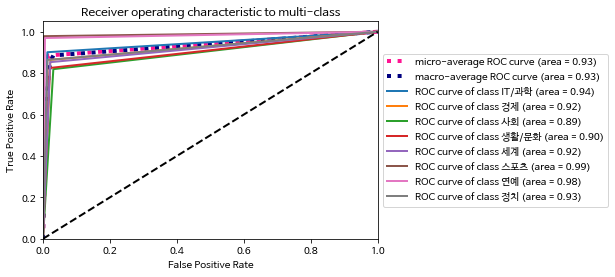

In [92]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

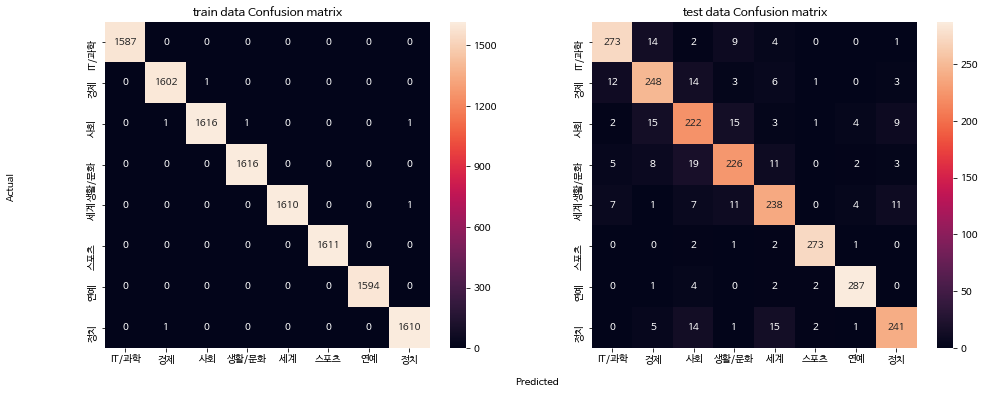

In [93]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [94]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.908289241622575
classification report
             precision    recall  f1-score   support

          0       0.92      0.93      0.93       303
          1       0.88      0.86      0.87       287
          2       0.81      0.83      0.82       271
          3       0.86      0.88      0.87       274
          4       0.89      0.90      0.89       279
          5       0.98      0.98      0.98       279
          6       0.98      0.98      0.98       296
          7       0.94      0.89      0.91       279

avg / total       0.91      0.91      0.91      2268

CPU times: user 1min 2s, sys: 715 ms, total: 1min 3s
Wall time: 1min 13s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

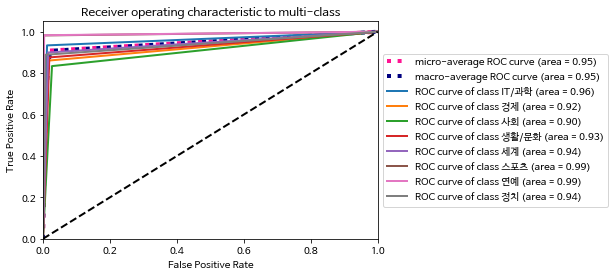

In [95]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

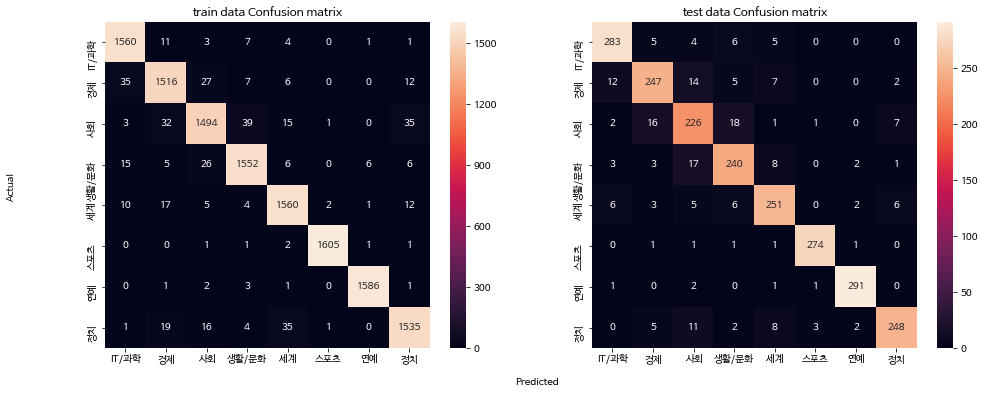

In [96]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [97]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 64.7 ms, sys: 40.9 ms, total: 106 ms
Wall time: 180 ms


In [98]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.77367	eval-mlogloss:1.80364
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.55588	eval-mlogloss:1.61027
[2]	train-mlogloss:1.38296	eval-mlogloss:1.45478
[3]	train-mlogloss:1.24512	eval-mlogloss:1.33539
[4]	train-mlogloss:1.1317	eval-mlogloss:1.23624
[5]	train-mlogloss:1.03329	eval-mlogloss:1.14998
[6]	train-mlogloss:0.947386	eval-mlogloss:1.07159
[7]	train-mlogloss:0.872528	eval-mlogloss:1.0052
[8]	train-mlogloss:0.806368	eval-mlogloss:0.946894
[9]	train-mlogloss:0.746165	eval-mlogloss:0.895395
[10]	train-mlogloss:0.693334	eval-mlogloss:0.849955
[11]	train-mlogloss:0.646177	eval-mlogloss:0.807836
[12]	train-mlogloss:0.602761	eval-mlogloss:0.769844
[13]	train-mlogloss:0.564804	eval-mlogloss:0.736612
[14]	train-mlogloss:0.530254	eval-mlogloss:0.70593
[15]	train-mlogloss:0.497578	eval-mlogloss:0.67788
[16]	train-mlogloss:0.468712	eval-mlogloss:0.

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

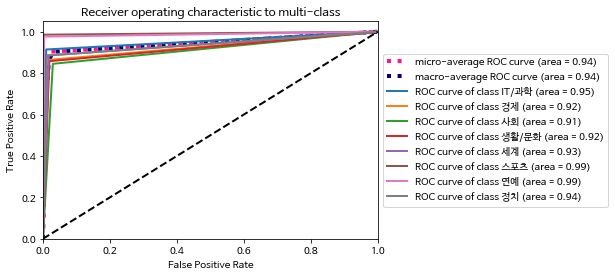

In [99]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

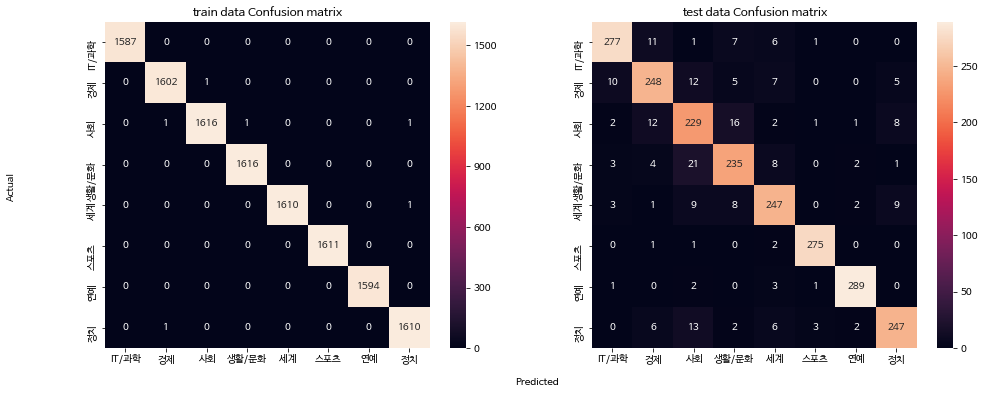

In [100]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [101]:
del classifier
del classifier2
del classifier3
del gbm

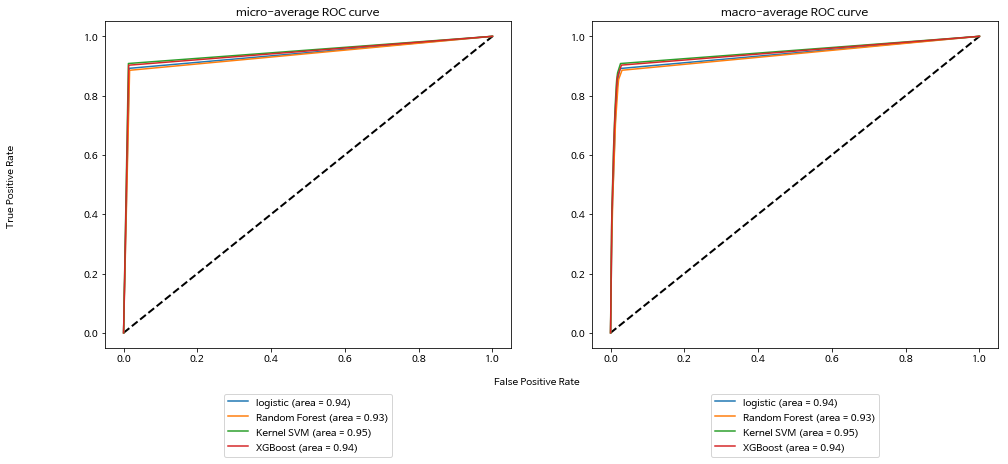

In [102]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [103]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [104]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5646
Accuracy: 0.8986


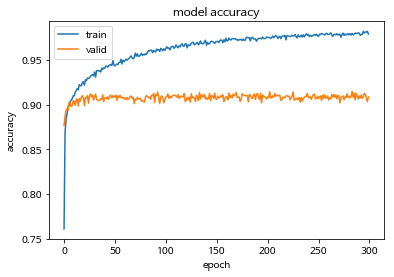

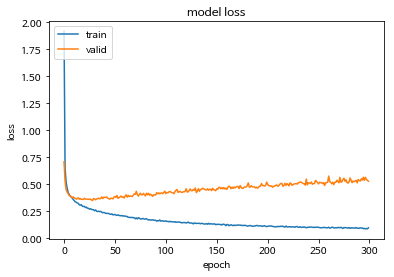

In [105]:
bm.plot_history(history)

In [106]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.8109
Accuracy: 0.8986


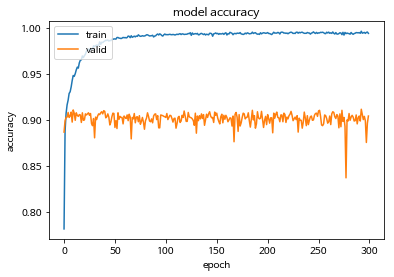

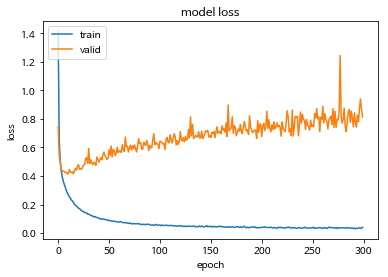

In [107]:
bm.plot_history(history)

### model 2

In [108]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model2, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model2,'mecab')

  9%|▉         | 7383/80260 [00:00<00:01, 36907.73it/s]

Word2Vec(vocab=80260, size=500, alpha=0.025)


100%|██████████| 80260/80260 [00:01<00:00, 69155.48it/s]
1it [00:00,  5.41it/s]

running time : 0:00:01.176570
Vectorizing Train Data


12852it [02:43, 78.53it/s]


scaling Train Data


5it [00:00, 43.95it/s]

running time : 0:02:43.988069
Vectorizing Test Data


2268it [00:27, 81.71it/s]


scaling Test Data
running time : 0:00:27.825879
total running time : 0:03:12.990518


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [109]:
%%time
bm.Make_TSNE2(2, model2, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 102246.23it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.525s...
[t-SNE] Computed neighbors for 10000 samples in 102.810s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.295034
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.698624
[t-SNE] Error after 1000 iterations: 2.800225


CPU times: user 11min 3s, sys: 55.8 s, total: 11min 59s
Wall time: 12min 31s


#### 분류모델 :  Logistic Regression

In [110]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.900352733686067
classification report
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       303
          1       0.86      0.86      0.86       287
          2       0.80      0.80      0.80       271
          3       0.87      0.87      0.87       274
          4       0.88      0.87      0.88       279
          5       0.98      0.99      0.98       279
          6       0.98      0.99      0.98       296
          7       0.90      0.86      0.88       279

avg / total       0.90      0.90      0.90      2268

CPU times: user 1min 1s, sys: 859 ms, total: 1min 2s
Wall time: 1min 10s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

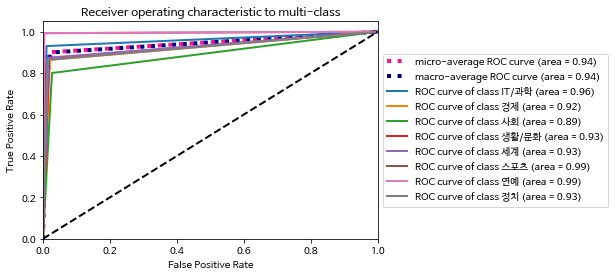

In [111]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

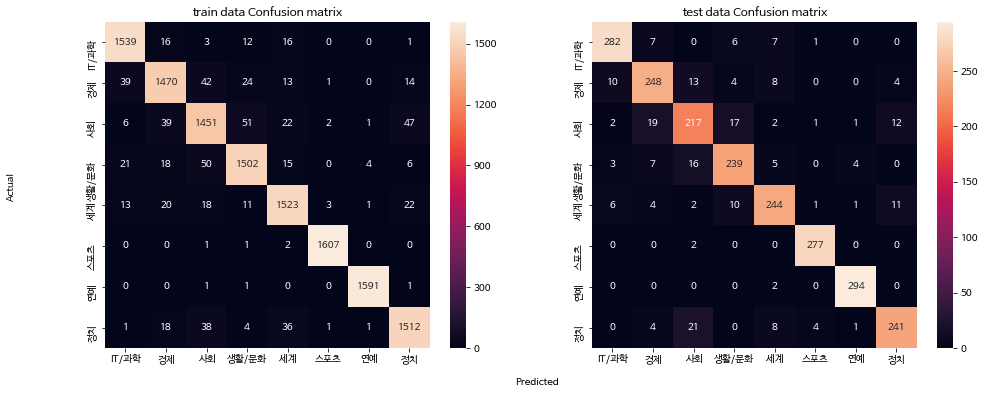

In [112]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [113]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8981481481481481
classification report
             precision    recall  f1-score   support

          0       0.89      0.93      0.91       303
          1       0.87      0.85      0.86       287
          2       0.81      0.83      0.82       271
          3       0.88      0.86      0.87       274
          4       0.89      0.86      0.87       279
          5       0.99      0.99      0.99       279
          6       0.96      0.97      0.96       296
          7       0.89      0.89      0.89       279

avg / total       0.90      0.90      0.90      2268

CPU times: user 35.9 s, sys: 306 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

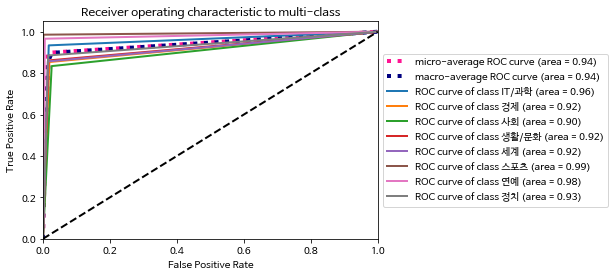

In [114]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

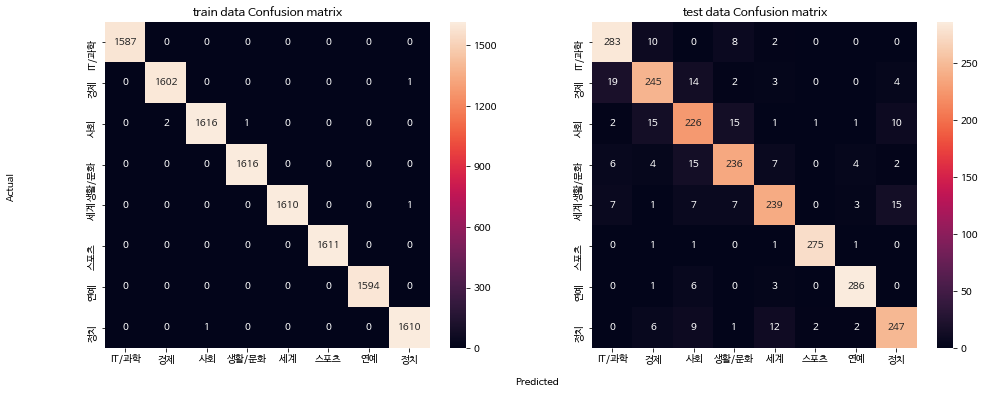

In [115]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [116]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9144620811287478
classification report
             precision    recall  f1-score   support

          0       0.92      0.94      0.93       303
          1       0.87      0.85      0.86       287
          2       0.82      0.85      0.83       271
          3       0.90      0.89      0.90       274
          4       0.92      0.90      0.91       279
          5       0.99      0.99      0.99       279
          6       0.98      0.99      0.98       296
          7       0.92      0.91      0.91       279

avg / total       0.91      0.91      0.91      2268

CPU times: user 40.9 s, sys: 613 ms, total: 41.5 s
Wall time: 48.6 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

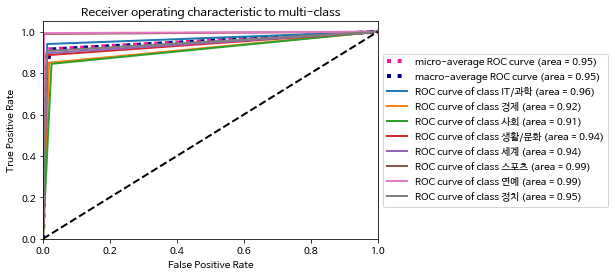

In [117]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

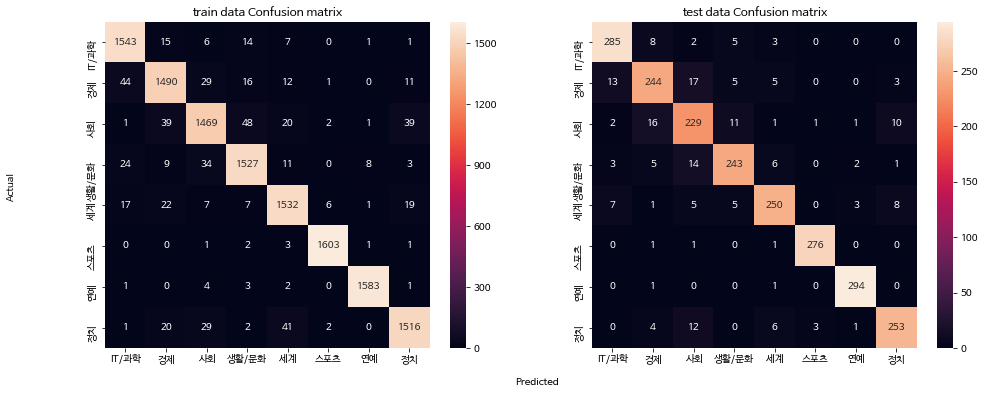

In [118]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [119]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 72.2 ms, sys: 54 ms, total: 126 ms
Wall time: 342 ms


In [120]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.63949	eval-mlogloss:1.65858
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.3804	eval-mlogloss:1.41657
[2]	train-mlogloss:1.18831	eval-mlogloss:1.23769
[3]	train-mlogloss:1.04038	eval-mlogloss:1.09788
[4]	train-mlogloss:0.919719	eval-mlogloss:0.988721
[5]	train-mlogloss:0.819542	eval-mlogloss:0.897489
[6]	train-mlogloss:0.734997	eval-mlogloss:0.820688
[7]	train-mlogloss:0.663755	eval-mlogloss:0.756801
[8]	train-mlogloss:0.602455	eval-mlogloss:0.701794
[9]	train-mlogloss:0.549702	eval-mlogloss:0.654294
[10]	train-mlogloss:0.503794	eval-mlogloss:0.614161
[11]	train-mlogloss:0.463693	eval-mlogloss:0.579022
[12]	train-mlogloss:0.428718	eval-mlogloss:0.548927
[13]	train-mlogloss:0.397823	eval-mlogloss:0.521393
[14]	train-mlogloss:0.369557	eval-mlogloss:0.49721
[15]	train-mlogloss:0.344299	eval-mlogloss:0.476236
[16]	train-mlogloss:0.32251	eval-mlog

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

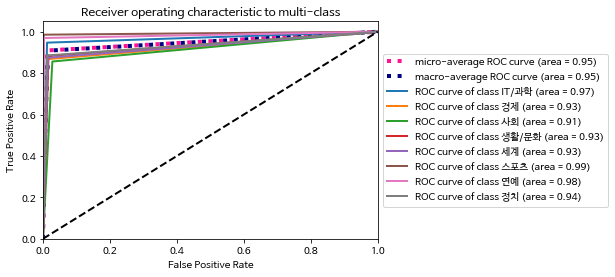

In [121]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

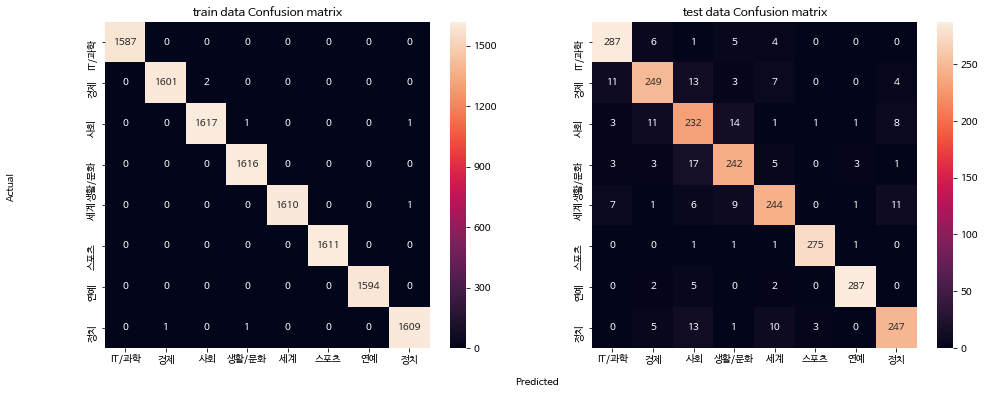

In [122]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [123]:
del classifier
del classifier2
del classifier3
del gbm

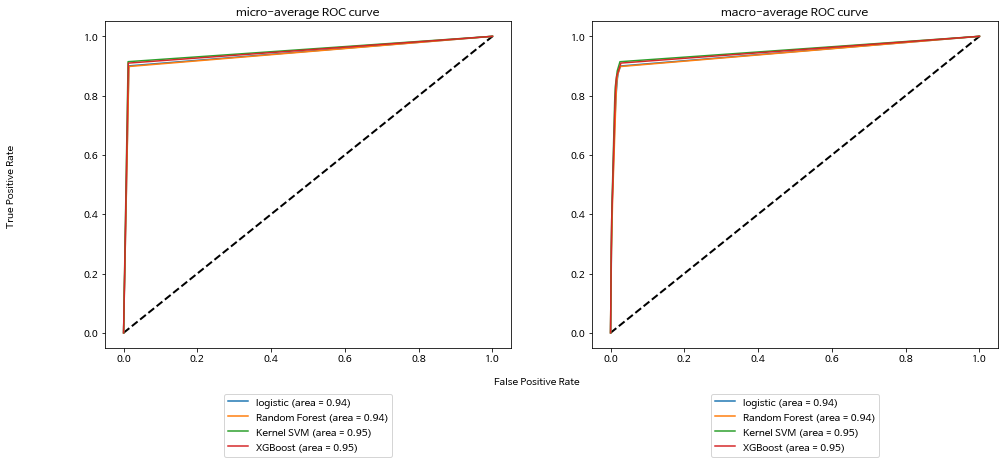

In [124]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [125]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [126]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5195
Accuracy: 0.9017


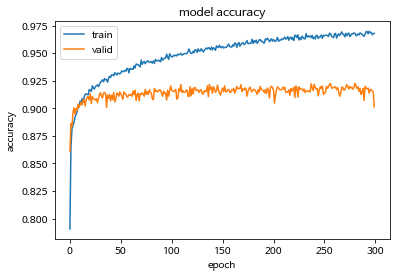

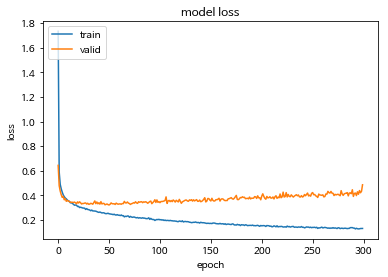

In [127]:
bm.plot_history(history)

In [128]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.6840
Accuracy: 0.9052


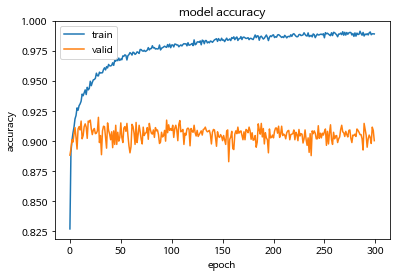

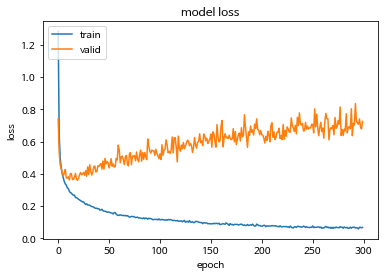

In [129]:
bm.plot_history(history)

#### model 3

In [130]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model3, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model3,'mecab')

 17%|█▋        | 13794/80260 [00:00<00:00, 68957.16it/s]

Word2Vec(vocab=80260, size=500, alpha=0.025)


100%|██████████| 80260/80260 [00:01<00:00, 71496.26it/s]
0it [00:00, ?it/s]

running time : 0:00:01.128387
Vectorizing Train Data


12852it [02:38, 81.15it/s]


scaling Train Data


9it [00:00, 82.54it/s]

running time : 0:02:38.736422
Vectorizing Test Data


2268it [00:27, 81.64it/s]


scaling Test Data
running time : 0:00:27.898366
total running time : 0:03:07.763175


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [131]:
%%time
bm.Make_TSNE2(2, model3, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 83133.88it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.469s...
[t-SNE] Computed neighbors for 10000 samples in 100.173s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.253906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.571754
[t-SNE] Error after 1000 iterations: 3.185745


CPU times: user 10min 50s, sys: 55.4 s, total: 11min 45s
Wall time: 11min 14s


#### 분류모델 :  Logistic Regression

In [132]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.9078483245149912
classification report
             precision    recall  f1-score   support

          0       0.90      0.93      0.92       303
          1       0.88      0.85      0.87       287
          2       0.84      0.81      0.82       271
          3       0.88      0.88      0.88       274
          4       0.88      0.89      0.89       279
          5       0.98      0.99      0.98       279
          6       0.98      1.00      0.99       296
          7       0.91      0.91      0.91       279

avg / total       0.91      0.91      0.91      2268

CPU times: user 44.7 s, sys: 394 ms, total: 45.1 s
Wall time: 50.6 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

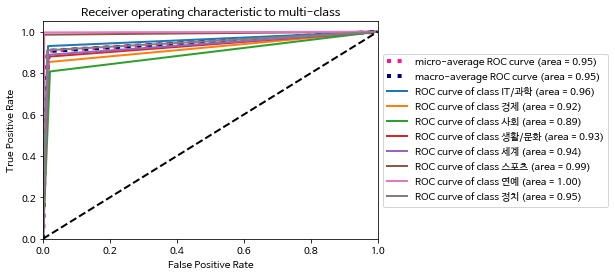

In [133]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

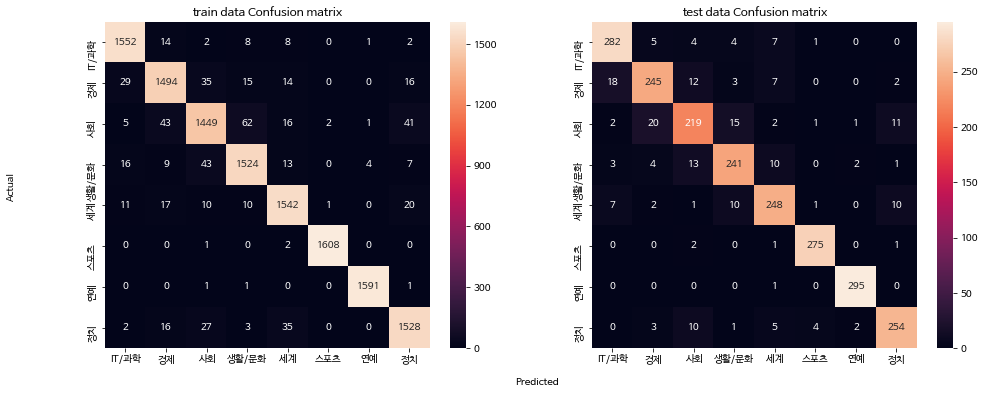

In [134]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [135]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8977072310405644
classification report
             precision    recall  f1-score   support

          0       0.92      0.93      0.93       303
          1       0.86      0.87      0.87       287
          2       0.80      0.80      0.80       271
          3       0.88      0.86      0.87       274
          4       0.88      0.87      0.88       279
          5       0.99      0.99      0.99       279
          6       0.95      0.98      0.97       296
          7       0.89      0.86      0.88       279

avg / total       0.90      0.90      0.90      2268

CPU times: user 34.1 s, sys: 229 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

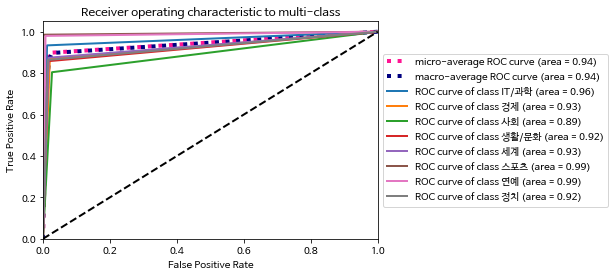

In [136]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

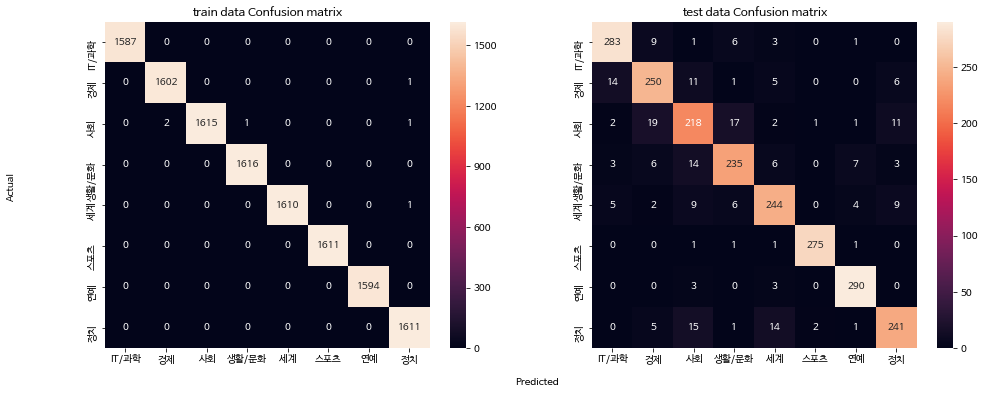

In [137]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [138]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.923721340388007
classification report
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       303
          1       0.89      0.88      0.88       287
          2       0.83      0.85      0.84       271
          3       0.90      0.90      0.90       274
          4       0.93      0.91      0.92       279
          5       0.99      0.99      0.99       279
          6       0.99      0.99      0.99       296
          7       0.94      0.91      0.93       279

avg / total       0.92      0.92      0.92      2268

CPU times: user 47.1 s, sys: 587 ms, total: 47.7 s
Wall time: 53.2 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

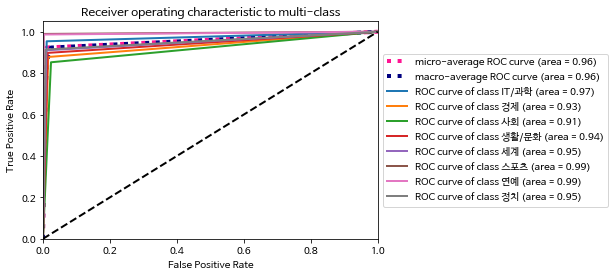

In [139]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

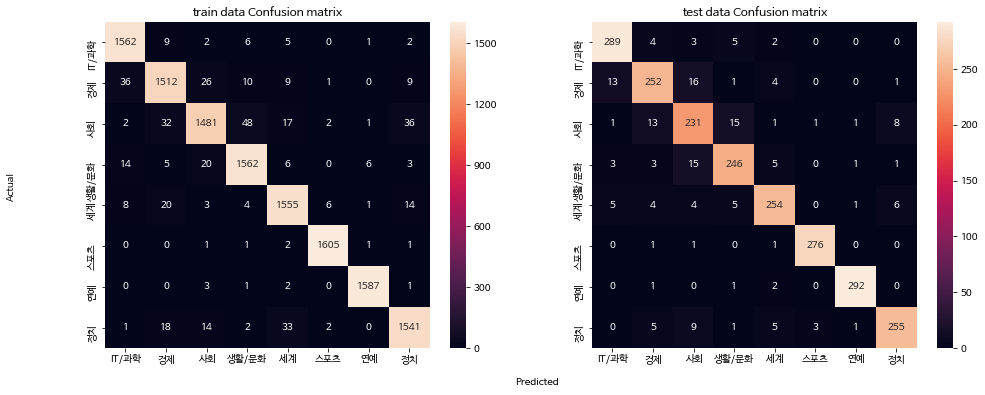

In [140]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [141]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 79.5 ms, sys: 59.7 ms, total: 139 ms
Wall time: 223 ms


In [142]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.67815	eval-mlogloss:1.69311
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.43107	eval-mlogloss:1.45809
[2]	train-mlogloss:1.24572	eval-mlogloss:1.28684
[3]	train-mlogloss:1.09936	eval-mlogloss:1.15122
[4]	train-mlogloss:0.979252	eval-mlogloss:1.04043
[5]	train-mlogloss:0.880165	eval-mlogloss:0.950301
[6]	train-mlogloss:0.7947	eval-mlogloss:0.872674
[7]	train-mlogloss:0.722308	eval-mlogloss:0.807829
[8]	train-mlogloss:0.658226	eval-mlogloss:0.752873
[9]	train-mlogloss:0.603841	eval-mlogloss:0.703962
[10]	train-mlogloss:0.555466	eval-mlogloss:0.661411
[11]	train-mlogloss:0.512566	eval-mlogloss:0.624673
[12]	train-mlogloss:0.475631	eval-mlogloss:0.593045
[13]	train-mlogloss:0.442363	eval-mlogloss:0.564549
[14]	train-mlogloss:0.411609	eval-mlogloss:0.538467
[15]	train-mlogloss:0.384472	eval-mlogloss:0.515144
[16]	train-mlogloss:0.36018	eval-mlogl

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

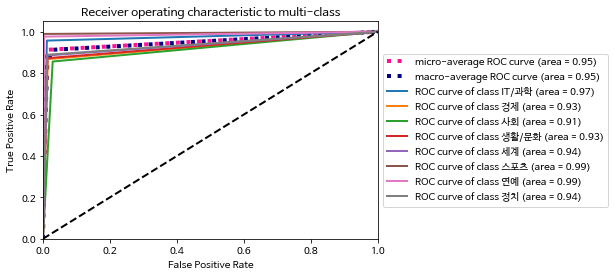

In [143]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

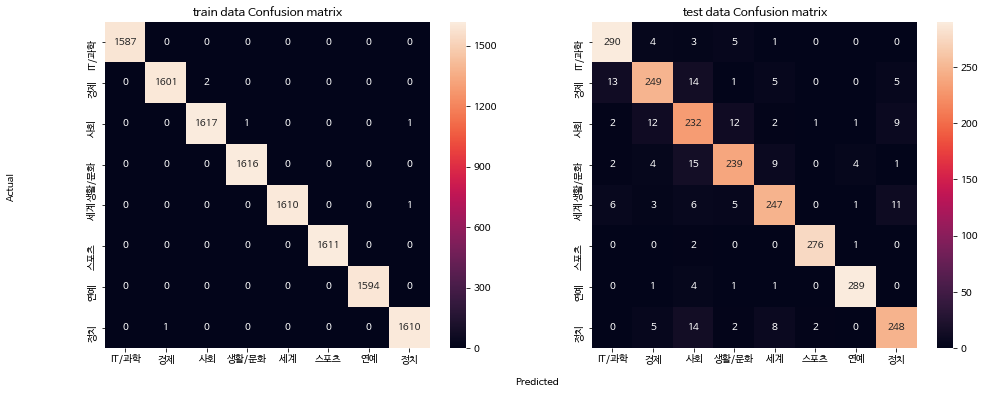

In [144]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [145]:
del classifier
del classifier2
del classifier3
del gbm

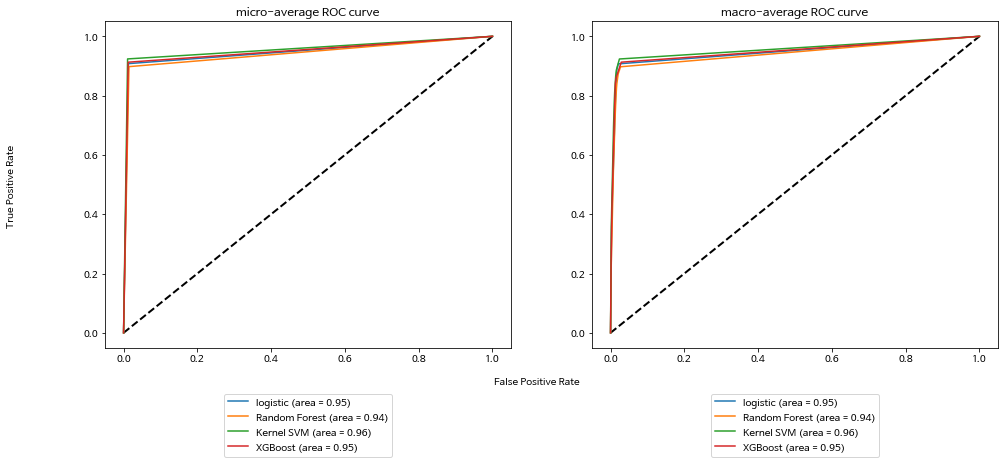

In [146]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [147]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [148]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.4824
Accuracy: 0.9149


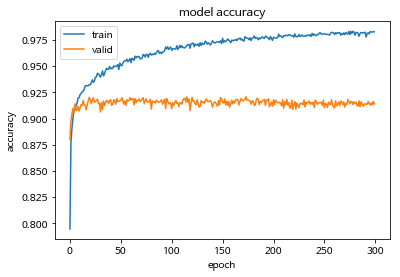

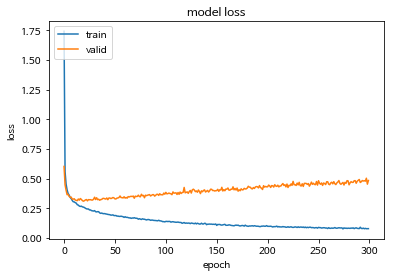

In [149]:
bm.plot_history(history)

In [150]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.7275
Accuracy: 0.9026


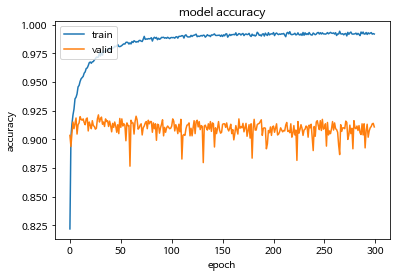

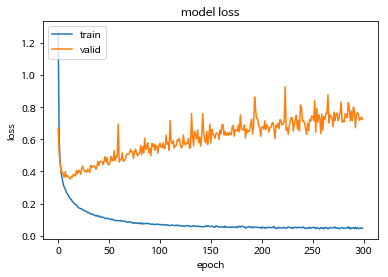

In [151]:
bm.plot_history(history)